<a href="https://colab.research.google.com/github/plantroots/flowers-multi-class-classifier/blob/main/flowers_multi_class_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!nvidia-smi

Thu Mar 31 14:55:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip "/content/drive/MyDrive/Deep Learning/Datasets/flowers.zip" -d "/content/dataset"

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import pickle

from PIL import Image
from google.colab import files
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

***General overview of the data***

In [ ]:
BASE_DIR = "/content/dataset/flowers"
CATEGORIES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [ ]:
def exclude_corrupted(files, dir):
  healthy_files = []
  for f in files:
    if os.path.getsize(os.path.join(dir, f)) > 0:
      healthy_files.append(f)
  return healthy_files

DIRS = {}
FILES = {}

for category in CATEGORIES:
  DIRS[category] = os.path.join(BASE_DIR, category)
  FILES[category] = os.listdir(DIRS[category])

  print(f"{category} images:", len(FILES[category]), "-->", 
    len(exclude_corrupted(FILES[category], DIRS[category])), "healthy files")


daisy images: 764 --> 764 healthy files
dandelion images: 1052 --> 1052 healthy files
rose images: 784 --> 784 healthy files
sunflower images: 733 --> 733 healthy files
tulip images: 984 --> 984 healthy files


In [ ]:
for cat in CATEGORIES:
  widths = []
  heights = []
  
  for f in FILES[cat]:
    filepath = os.path.join(DIRS[cat], f)
    img = Image.open(filepath)
    widths.append(img.width)
    heights.append(img.height)

  print(f"{cat} dims:", {"max_width": max(widths), "min_width": min(widths),
          "max_height": max(heights), "min_height": min(heights), 
          "avg_width": round(sum(widths)/len(widths)),
          "avg_height": round(sum(heights)/len(heights))})

daisy dims: {'max_width': 640, 'min_width': 134, 'max_height': 442, 'min_height': 134, 'avg_width': 332, 'avg_height': 253}
dandelion dims: {'max_width': 500, 'min_width': 134, 'max_height': 436, 'min_height': 98, 'avg_width': 347, 'avg_height': 259}
rose dims: {'max_width': 500, 'min_width': 150, 'max_height': 434, 'min_height': 80, 'avg_width': 327, 'avg_height': 244}
sunflower dims: {'max_width': 640, 'min_width': 152, 'max_height': 400, 'min_height': 134, 'avg_width': 348, 'avg_height': 262}
tulip dims: {'max_width': 1024, 'min_width': 134, 'max_height': 441, 'min_height': 134, 'avg_width': 336, 'avg_height': 248}


***Prepare folder structure for split***

In [ ]:
split_dir = "/content/dataset/"

os.system(f"mkdir {split_dir}/train")
os.system(f"mkdir {split_dir}/test")

for cat in CATEGORIES:
  os.system(f"mkdir {split_dir}/train/{cat}")
  os.system(f"mkdir {split_dir}/test/{cat}")

In [ ]:
# display in the dims they will enter the neural net as a sanity check
def display_img(category, index):
  random.shuffle(FILES[category])
  count = 0
  for f in FILES[category]:
    if count < index:
      filepath = os.path.join(DIRS[category], f)
      img = Image.open(filepath)
      img = img.resize((340,250))
      count += 1
      display(img)

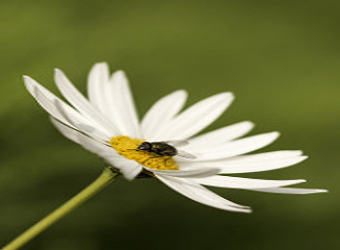

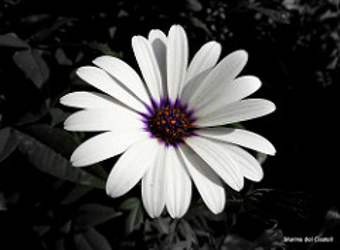

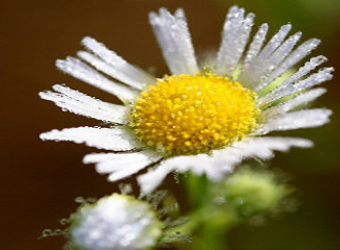

In [ ]:
display_img("daisy", 3)

***Split and move files***

In [ ]:
def train_validation_split(percentage=0.8):
  base = "/content/dataset"
  originals = "/content/dataset/flowers"
  for category, path in list(DIRS.items()):
    files = os.listdir(path)
    threshold = int(len(files) * percentage)
    train = files[:threshold]
    test = files[threshold:]

    train_dir = os.path.join(base, 'train', category)
    test_dir = os.path.join(base, 'test', category)

    for f in train:
      os.system(f"mv {os.path.join(originals, category, f)} {os.path.join(train_dir, f)}")
      
    for f in test:
      os.system(f"mv {os.path.join(originals, category, f)} {os.path.join(test_dir, f)}")

  
train_validation_split(0.8)

In [ ]:
TRAINING_DIR = "/content/dataset/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/dataset/test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(340,250),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(340,250),
	class_mode='categorical',
  batch_size=32
)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [ ]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
# 100 epcohs --> 67s 614ms/step - loss: 0.2461 - accuracy: 0.9105 - val_loss: 0.4482 - val_accuracy: 0.8694
tf.random.set_seed(1894)

input = layers.Input((340,250,3))
x = layers.Conv2D(64, (3,3), activation="relu")(input)
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(512, (5,5), activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(1024, (5,5), activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(1024, (5,5), activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(5, activation="softmax")(x)

model = Model(inputs=input, outputs=x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 340, 250, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 338, 248, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 338, 248, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 169, 124, 128)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 167, 122, 256)     295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 83, 61, 256)      0         
 2D)                                                       

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1)

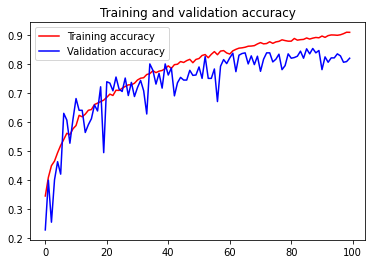

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# load model
# model = load_model("/content/drive/MyDrive/Deep Learning/Models/flowers")

Saving daisy 1.jpg to daisy 1 (1).jpg
Saving dandelion 1.jpg to dandelion 1 (1).jpg
Saving rose 1.jpg to rose 1 (1).jpg
Saving rose 2_.jpg to rose 2_.jpg
Saving sunflower 1.jpg to sunflower 1 (5).jpg
Saving tulip.jpeg to tulip.jpeg
Saving tulip 2.jpeg to tulip 2.jpeg


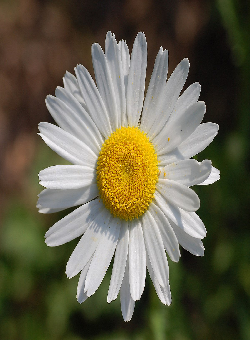

It's a daisy


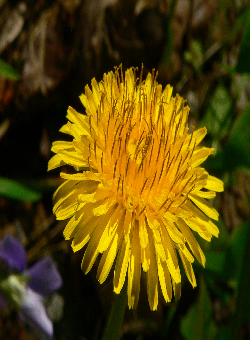

It's a dandelion


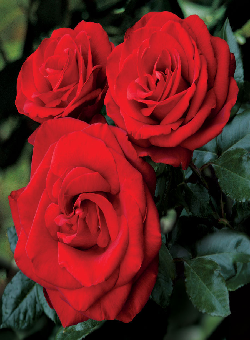

It's a rose


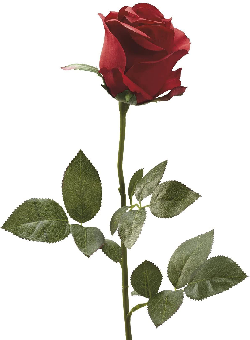

It's a sunflower


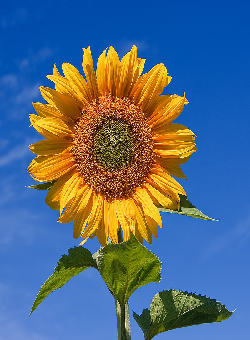

It's a sunflower


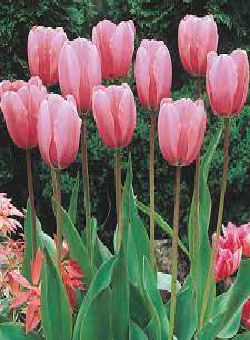

It's a tulip


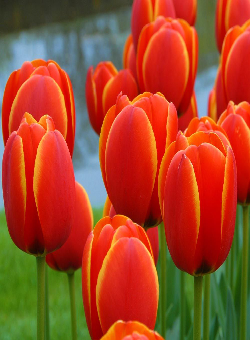

It's a tulip


In [ ]:
uploaded = files.upload()

def asign_category(class_index):
  if class_index == 0:
    print("It's a daisy")
  elif class_index == 1:
    print("It's a dandelion")
  elif class_index == 2:
    print("It's a rose")
  elif class_index == 3:
    print("It's a sunflower")
  else:
    print("It's a tulip")

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(340, 250))
  display(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  # print(fn)
  asign_category(np.argmax(classes[0]))

In [ ]:
# # save model
# model.save("/content/drive/MyDrive/Deep Learning/Models/flowers")

In [ ]:
# # save history
# with open('/content/drive/MyDrive/Deep Learning/Models/flowers_history', 'wb') as f:
#       pickle.dump(history.history, f)

In [ ]:
# # load history
# with open("/content/drive/MyDrive/Deep Learning/Models/history/flowers_history", "rb") as f:
#   history = pickle.load(f)

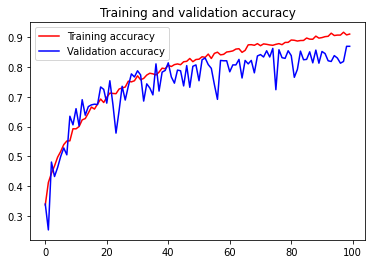

<Figure size 432x288 with 0 Axes>

In [ ]:
# from matplotlib import pyplot as plt

# acc = history['accuracy']
# val_acc = history['val_accuracy']
# loss = history['loss']
# val_loss = history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.show()